# RU36 March 2022 Mission Processing

JG 04/04/2022 <br>


In [1]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os,sys
import glob
import datetime
#import cmocean.cm as cmo
import xarray as xr
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from scipy.spatial.transform import Rotation as R
import scipy.interpolate as interp
from scipy import stats

from erddapy import ERDDAP
import struct
import pylab as plot
# import metpy.calc as mt
# from metpy.units import units

sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import inversion, shear_method, qaqc_post_coord_transform

myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%y/%m/%d\n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


## Some Functions

In [2]:
def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds




# Newest version 05/04/2022
## Setting time origin
rtime=datetime.datetime(2020,1,1,0,0,0)

## Read in binary PD0 file
def read_PD0(infile):
    global time,depth,pitch,roll,heading,temp,bins, hdbias
    global u1,u2,u3,u4
    global c1,c2,c3,c4
    global ei1,ei2,ei3,ei4
    global pg1,pg2,pg3,pg4
    print('Reading PDO file : '+infile)
    
    ## Open file and read in binary
    f=open(infile,'rb')
    dat = f.read()
    f.close()
    
    ## All this does is try to find the byte location of the first ensemble. 
    ## Usually its the first byte, but it some applications it is not.  
    ## It searches for the header ID and source ID (both '0x7f')
    ## See Chapter 8 of  PathFinder DVL Guide_Apr20.pdf 
    for [ind,tmp1] in enumerate(dat):
          if hex(dat[ind])=='0x7f' and hex(dat[ind+1]) =='0x7f':                 
                  break
    
    ## This extracts the number of bytes per ensemble. 
    nbytes=struct.unpack("h",dat[ind+2:ind+4])[0]+2
#    print('Finding Ensembles')      


    ## Find the starting byte of every ensemble. (Varaible Iens)
    ## It goes through every byte and searchs for header ID's and source ID's
    ## When one is found, the index is added to the variable Iens 
    Iens=[] ## Starting byte of each ensemble. 
    nind=0
    n=0
    for [ind,tmp1] in enumerate(dat):
          if hex(dat[ind])=='0x7f':
          #if hex(dat[ind])=='0x7f' and hex(dat[ind+1]) =='0x7f':
              n=n+1
              nbytes2=struct.unpack("h",dat[ind+2:ind+4])[0]+2  
             
              startens=ind
              tdat=dat[startens:startens+nbytes]
              if len(tdat)<nbytes:
                   print('breaking')
                   break
              tmp=tdat[nbytes-2:nbytes]
              chksum=struct.unpack("<H",tmp)[0]
              if (sum(tdat[:nbytes-2]) & 65535) ==  chksum:
                      
                   if nbytes == nbytes2:
  
                       nind=ind
                       Iens.append(ind)
 #             else:
 #                print('Bad Checksum')

    nens=len(Iens)

## nens is number of ensembles, so this chunk is preallocating variables that will
## be read in. Is the 100 for the 2-dimensional variables just a "safe" number of bins
## without knowing exactly how many. There's a better way to do this...
    time=np.empty((nens),np.double)    
    depth=np.empty((nens),np.double) 
    pitch=np.empty((nens),np.double) 
    roll=np.empty((nens),np.double) 
    heading=np.empty((nens),np.double) 
    temp=np.empty((nens),np.double)
    
    u1=np.empty((nens,100),np.double) 
    u2=np.empty((nens,100),np.double) 
    u3=np.empty((nens,100),np.double)
    u4=np.empty((nens,100),np.double)  
    ei1=np.empty((nens,100),np.double) 
    ei2=np.empty((nens,100),np.double) 
    ei3=np.empty((nens,100),np.double)
    ei4=np.empty((nens,100),np.double)  
    c1=np.empty((nens,100),np.double) 
    c2=np.empty((nens,100),np.double) 
    c3=np.empty((nens,100),np.double)
    c4=np.empty((nens,100),np.double)   
    pg1=np.empty((nens,100),np.double) 
    pg2=np.empty((nens,100),np.double) 
    pg3=np.empty((nens,100),np.double)
    pg4=np.empty((nens,100),np.double)    
    xform=np.zeros((4,4),np.double)   
    xformR=np.zeros((3,3),np.double)
    xformP=np.zeros((3,3),np.double)
    xformH=np.zeros((3,3),np.double)

    ind=0
    eoffset=0
#    Iens=Iens[0:nens]

## Loop through ensembles and pull out data.
## Which bytes correspiond to what variables is detailed in the Pathfinder manual Ch 8. This is standard for PD0s?
    for ind2 in Iens:
        startens=(ind2)
        tdat=dat[startens:startens+nbytes]
        # a=buffer(tdat,2,2)
        tnbytes=struct.unpack("H",tdat[2:4])[0]+2
        # a=buffer(tdat,nbytes-2,2)
        chksum=struct.unpack("<H",tdat[nbytes-2:nbytes])[0]

        ## In the past binary data was subject to erros (missing bytes)during read/writing/data transfer operations. 
        ## It is common practive to add a Checksum to the end of the data. 
        ## i.e. the last 2 bytes of the ensemble represent the "sum" of every byte in the ensemble. 
        ## if they do not match, data was lost in the ensemble. This happens rarely.
        if (sum(tdat[:nbytes-2]) & 65535) ==  chksum:
              ndtype=struct.unpack("b",tdat[5:6])[0]
 
              offsets=list()
              for ind3 in range(ndtype):
                   Is=6+ind3*2
                   offsets.append(struct.unpack_from("h",tdat[Is:Is+2])[0])        
            
            ## FIXEDLEADER
            ## Number of beams
              Is=offsets[0]+8
              nbeam=tdat[Is]
            ## Number of cells
              Is=offsets[0]+9
              ncells=tdat[Is]  
            ## Cell size
              Is=offsets[0]+12
              cellsize=struct.unpack("H",tdat[Is:Is+2])[0]        
              cellsize=cellsize/100.0       
            ## Bin 1 distance in cm --> meters
              Is=offsets[0]+32
              bin1=struct.unpack("H",tdat[Is:Is+2])[0]    
              bin1=bin1/100.0
            ## Heading alignment/100 to get degrees    
              Is=offsets[0]+26
              hdalign=struct.unpack("H",tdat[Is:Is+2])[0]    
              hdalign=hdalign/100.0
            ## Heading bias/100 to get degrees
              Is=offsets[0]+28
              hdbias=struct.unpack("H",tdat[Is:Is+2])[0]    
              hdbias=hdbias/100.0
            
              Is=offsets[0]+4
              # sysconfig1=bin(tdat[Is])   
              sysconfig1=format(tdat[Is], '#010b')[2:]
              Is=offsets[0]+5
              # sysconfig2=bin(tdat[Is]) 
              sysconfig2=format(tdat[Is], '#010b')[2:]
            
            ## Beam angle correction
              if sysconfig2[-2:]=='10':
                  bmang=30.0
              elif sysconfig2[-2:]=='01':
                  bmang=20.0
              elif sysconfig2[-2:]=='00':
                  bmang=15.0
              a=1.0/(2.0*np.sin(bmang*np.pi/180.0))
              b=1.0/(4.0*np.cos(bmang*np.pi/180.0))
              c=1.0
              d=a/np.sqrt(2.0)
            ## Building transformation matrix for beam to instrument
              xform[0,0]=c*a  
              xform[0,1]=-c*a
              xform[0,2]=0.0
              xform[0,3]=0.0  
            
              xform[1,0]=0.0  
              xform[1,1]=0.0
              xform[1,2]=-c*a
              xform[1,3]=c*a
              
              xform[2,0]=b  
              xform[2,1]=b
              xform[2,2]=b
              xform[2,3]=b
              
              xform[3,0]=d  
              xform[3,1]=d
              xform[3,2]=-d
              xform[3,3]=-d

              Is=offsets[1]+2
              ens=struct.unpack("H",tdat[Is:Is+2])[0]        
              
              
     
            ## Read in time data
              Is=offsets[1]+4
              year=tdat[Is]  
        
              Is=offsets[1]+5
              month=tdat[Is]
              Is=offsets[1]+6
              day=tdat[Is]
              Is=offsets[1]+7
              hour=tdat[Is]
              Is=offsets[1]+8
              minute=tdat[Is]
              Is=offsets[1]+9
              sec=tdat[Is]
              Is=offsets[1]+10
              hsec=tdat[Is]

              ttime = datetime.datetime(year+2000,month,day,hour,minute,sec,hsec*10)-rtime
            ## Read in depth data
              Is=offsets[1]+16
              tdepth=struct.unpack("H",tdat[Is:Is+2])[0]   
            ## Convert depth from decimeters to meters
              tdepth=tdepth*0.1
            ## Read in temporary heading
              Is=offsets[1]+18
              theading=struct.unpack("H",tdat[Is:Is+2])[0]     
              theading=theading/100.0
            ## Read in pitch data
              Is=offsets[1]+20
              tpitch=struct.unpack("h",tdat[Is:Is+2])[0]        
              tpitch=tpitch/100.0 
            ## Read in roll data
              Is=offsets[1]+22
              troll=struct.unpack("h",tdat[Is:Is+2])[0]        
              troll=troll/100.0    
            ## Read in salinity data
              Is=offsets[1]+24
              tsalt=struct.unpack("h",tdat[Is:Is+2])[0]
            ## Read in temperature data
              Is=offsets[1]+26
              ttemp=struct.unpack("h",tdat[Is:Is+2])[0]        
              ttemp=ttemp/100.0       
            ## Read in glider pressure data
              Is=offsets[1]+48
              tpress=struct.unpack("i",tdat[Is:Is+4])[0]        
              tpress=tpress/1000.0       
            ## Read in velocity data
              Is=offsets[2]+2
              fmt = "<%dh" % (ncells*4)
              uvw=struct.unpack(fmt,tdat[Is:Is+ncells*4*2])
              uvw=np.array(uvw,dtype=float)
            ## Read in echo intensity data
              Is=offsets[3]+2
              fmt = "<%dB" % (ncells*4)
              tEI=struct.unpack(fmt,tdat[Is:Is+ncells*4])
              tEI=np.array(tEI)
            ## Read in correlation data
              Is=offsets[4]+2
              fmt = "<%dB" % (ncells*4)
              tC=struct.unpack(fmt,tdat[Is:Is+ncells*4])
              tC=np.array(tC)  
            ## Read in percent good data
              Is=offsets[5]+2
              fmt = "<%dB" % (ncells*4)
              tPG=struct.unpack(fmt,tdat[Is:Is+ncells*4])
              tPG=np.array(tPG)              
            ## Reshape velocity, ei, corr, and pg to be 2D based on cells and beams
              uvw.shape=(ncells,4)
              tEI.shape=(ncells,4)
              tC.shape=(ncells,4)
              tPG.shape=(ncells,4)
              
              ## QAQC Data
              uvw = qaqc_data(uvw, tEI, tC, tPG)              
              
            ## Create bins variable based on number of cells and cell size and reference it to distance from sensor based on bin1
              bins=(np.arange(0,ncells,1,np.double)*cellsize)+bin1    
            ## Read in bottom track data
              LO=len(offsets)
            
            ## When the ADCP writes the PD0, each ensemble (output profile) has a set of data types. i.e. fixed leader,
            ## variable leader, velocity, correltation, etc. Each data type has it's own header with an identifier.
            ## When we read a PD0 file, we read each ensemble one at a time.  (variable tdat in the script).
            ## Early in the ensemble, there is a variable called offsets, giving us the byte offset from the beginning
            ## of the  ensemble to the start of the data types in the file. If there is no bottom track, one of these
            ## offsets will be missing. So of LO>6, then there is bottom track  data to process. 

              if LO>6:
                  Is=offsets[6]
                  tmp1=struct.unpack("c",tdat[Is:Is+1])[0]
                  Is=offsets[6]+1
                  tmp2=struct.unpack("c",tdat[Is:Is+1])[0]
                  if [tmp1+tmp2]==[b'\x00\x06']:
                      Is=offsets[6]+16
                      tr1=struct.unpack("H",tdat[Is:Is+2])[0]       
                      Is=offsets[6]+18
                      tr2=struct.unpack("H",tdat[Is:Is+2])[0]    
                      Is=offsets[6]+20
                      tr3=struct.unpack("H",tdat[Is:Is+2])[0]    
                      Is=offsets[6]+22
                      tr4=struct.unpack("H",tdat[Is:Is+2])[0]     
                ## Convert bottom track range to meters
                      tr1=tr1/100.0     
                      tr2=tr2/100.0     
                      tr3=tr3/100.0     
                      tr4=tr4/100.0
                ## Only set velocity data below detected bottom equal to 0 if the bottom track range is greater than 0
                      if tr1>0:
                          uvw[bins>.85*tr1,0]=float("NAN")
                      if tr2>0:
                          uvw[bins>.85*tr2,1]=float("NAN")
                      if tr3>0:
                          uvw[bins>.85*tr3,2]=float("NAN")
                      if tr4>0:
                          uvw[bins>.85*tr4,3]=float("NAN")
                  
            ## Bin map velocity data based on pitch and roll
              uvw=mapdepthcells(uvw,tpitch,troll)
            ## This is where we actually build the arrays/vecotrs of the PD0 data. 
            ## ind is incremented at the end of the code block (ind=ind+1 below)
            ## It's how we add data to the variables we initialized earlier.  
              time[ind]=ttime.days+ttime.seconds/86400.0
                  
              depth[ind]=tdepth
              pitch[ind]=tpitch
              roll[ind]=troll
              temp[ind]=ttemp    
              heading[ind]=theading
            
            ## Correct heading
              shead=theading+hdalign
              
#               test_offset = 180
#               shead=theading+hdalign-test_offset
            
#               if shead<0:
#                     shead = shead + 360              
#               if shead>360:
#                     shead = shead - 360                                    
#               heading[ind] = shead
                                             
              
            ## Build beam to ENU transformation matrix
              CH=np.cos(shead*np.pi/180.0)
              SH=np.sin(shead*np.pi/180.0)
              CR=np.cos(troll*np.pi/180.0)
              SR=np.sin(troll*np.pi/180.0)
              CP=np.cos(tpitch*np.pi/180.0)
              SP=np.sin(tpitch*np.pi/180.0)
              # print(CP)
              # CP=np.cos(P)
              # print(CP)
              # SP=np.sin(P)
              
              xformH[0,0]=CH  
              xformH[0,1]=SH
              xformH[0,2]=0.0 
              xformH[1,0]=-SH 
              xformH[1,1]=CH
              xformH[1,2]=0.0 
              xformH[2,0]=0.0  
              xformH[2,1]=0.0
              xformH[2,2]=1.0 
            
              xformR[0,0]=CR  
              xformR[0,1]=0.0
              xformR[0,2]=SR 
              xformR[1,0]=0.0 
              xformR[1,1]=1.0
              xformR[1,2]=0.0 
              xformR[2,0]=-SR  
              xformR[2,1]=0.0
              xformR[2,2]=CR
              
              xformP[0,0]=1.0  
              xformP[0,1]=0.0
              xformP[0,2]=0.0 
              xformP[1,0]=0.0 
              xformP[1,1]=CP
              xformP[1,2]=-SP 
              xformP[2,0]=0.0  
              xformP[2,1]=SP
              xformP[2,2]=CP
              
            ## Convert from beam to ENU velocity
              uvw=uvw @ xform.transpose()
              terr=uvw[:,3]
              tuvw=uvw[:,0:3]
              tuvw=tuvw @ xformR.transpose()
              tuvw=tuvw @ xformP.transpose()
              tuvw=tuvw @ xformH.transpose()
            
              # u1[ind,0:ncells]=uvw[:,0]
              # u2[ind,0:ncells]=uvw[:,1]
              # u3[ind,0:ncells]=uvw[:,2]
              # u4[ind,0:ncells]=uvw[:,3]
              u1[ind,0:ncells]=tuvw[:,0] ## This is now U velocity
              u2[ind,0:ncells]=tuvw[:,1] ## This is now V velocity
              u3[ind,0:ncells]=tuvw[:,2] ## This is now W velocity
              u4[ind,0:ncells]=terr      ## This is now error velocity
              ei1[ind,0:ncells]=tEI[:,0] 
              ei2[ind,0:ncells]=tEI[:,1]
              ei3[ind,0:ncells]=tEI[:,2]
              ei4[ind,0:ncells]=tEI[:,3]
              c1[ind,0:ncells]=tC[:,0]
              c2[ind,0:ncells]=tC[:,1]
              c3[ind,0:ncells]=tC[:,2]
              c4[ind,0:ncells]=tC[:,3]
              pg1[ind,0:ncells]=tPG[:,0]
              pg2[ind,0:ncells]=tPG[:,1]
              pg3[ind,0:ncells]=tPG[:,2]
              pg4[ind,0:ncells]=tPG[:,3]            
              
              ind=ind+1
        else:
          #   print 'BAD CHECKSUM'
            # eoffset=eoffset+1
            
            continue
    
    
    u1=u1[:,0:ncells]
    u2=u2[:,0:ncells]
    u3=u3[:,0:ncells]
    u4=u4[:,0:ncells]
    c1=c1[:,0:ncells]
    c2=c2[:,0:ncells]
    c3=c3[:,0:ncells]
    c4=c4[:,0:ncells]
    ei1=ei1[:,0:ncells]
    ei2=ei2[:,0:ncells]
    ei3=ei3[:,0:ncells]
    ei4=ei4[:,0:ncells]
    pg1=pg1[:,0:ncells]
    pg2=pg2[:,0:ncells]
    pg3=pg3[:,0:ncells]
    pg4=pg4[:,0:ncells]
    

def mapdepthcells(uvw,tpitch,troll):
    global bins
 #   print('Mapping depth cells')
    brange=bins/np.cos(30*np.pi/180.0)
    tuvw=uvw*np.nan
    az=90*np.pi/180
    elev=-60*np.pi/180
    ## This is getting the actuall bin depths.(relative to glider), so we can transform them to "Level" bin depths 
    XYZ1 = sph2cart(az,elev,brange)
    
   
    az=-90*np.pi/180
    elev=-60*np.pi/180
    XYZ2 = sph2cart(az,elev,brange)
    
    az=0*np.pi/180
    elev=-60*np.pi/180
    XYZ3 = sph2cart(az,elev,brange) 
    
    az=180*np.pi/180
    elev=-60*np.pi/180
    XYZ4= sph2cart(az,elev,brange)

    rang1=tpitch*np.pi/(180) 
    rang2=troll*np.pi/(180) 
    sc=1/np.sqrt(2.0)
    ax1=sc*rang1*np.array([-1, 1, 0])
    ax2=sc*rang2*np.array([1, 1, 0])
    rmx1 = R.from_rotvec(ax1)
    rmx2 = R.from_rotvec(ax2)
    
    rot1=rmx1.as_matrix()    
    rot2=rmx2.as_matrix()
    rXYZ1=np.concatenate(([XYZ1[0]],[XYZ1[1]],[XYZ1[2]]),axis=0)
    r1=rXYZ1.transpose() @ rot1 @ rot2
    rXYZ2=np.concatenate(([XYZ2[0]],[XYZ2[1]],[XYZ2[2]]),axis=0)
    r2=rXYZ2.transpose() @ rot1  @ rot2
    rXYZ3=np.concatenate(([XYZ3[0]],[XYZ3[1]],[XYZ3[2]]),axis=0)
    r3=rXYZ3.transpose() @ rot1 @ rot2
    rXYZ4=np.concatenate(([XYZ4[0]],[XYZ4[1]],[XYZ4[2]]),axis=0)
    r4=rXYZ4.transpose() @ rot1 @ rot2

    tuvw[:,0]=np.interp(-r1[:,2],bins,uvw[:,0])
    tuvw[:,1]=np.interp(-r2[:,2],bins,uvw[:,1])
    tuvw[:,2]=np.interp(-r3[:,2],bins,uvw[:,2])
    tuvw[:,3]=np.interp(-r4[:,2],bins,uvw[:,3])

    return tuvw

def qaqc_data(uvw, tEI, tC, tPG):
    #print('PROCESSING DVL DATA')
    corr_cut = 50
    ei_cut   = 70
    pg_cut   = 80
    
        
    # Change filled values to NaN
    uvw[uvw == -32768] = float("NAN")
    
    # Convert from mm/s to m/s
    uvw = uvw/1000

    uvw[:,0][tC[:,0] < corr_cut] = float("NAN")
    uvw[:,1][tC[:,1] < corr_cut] = float("NAN")
    uvw[:,2][tC[:,2] < corr_cut] = float("NAN")
    uvw[:,3][tC[:,3] < corr_cut] = float("NAN")

    uvw[:,0][tEI[:,0] < ei_cut] = float("NAN")
    uvw[:,1][tEI[:,1] < ei_cut] = float("NAN")
    uvw[:,2][tEI[:,2] < ei_cut] = float("NAN")
    uvw[:,3][tEI[:,3] < ei_cut] = float("NAN")
    
    uvw[:,0][tPG[:,0] < pg_cut] = float("NAN")
    uvw[:,1][tPG[:,1] < pg_cut] = float("NAN")
    uvw[:,2][tPG[:,2] < pg_cut] = float("NAN")
    uvw[:,3][tPG[:,3] < pg_cut] = float("NAN")
    
    return(uvw)


    
def sph2cart(az,elev,r):
    z = r * np.sin(elev)
    rcoselev = r * np.cos(elev)
    x = rcoselev * np.cos(az)
    y = rcoselev * np.sin(az)
    return x,y,z;



## First read one PD0 and then loop through the rest of the files and append the data to create a master dataframe

In [3]:
# idir = '/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/'
    
# # files=glob.glob(idir+'*.pd0')
# # files.sort(key=os.path.getmtime)
# # file=files[13:-1] # I know file 13 is the first 2 meter bin
# # read_PD0(file[0])

# ## Test reading all?
# file=glob.glob(idir+'*.pd0')
# file.sort(key=os.path.getmtime)
# read_PD0(file[0])

# df = xr.Dataset(
#     {"heading" : (("time"),heading),
#      "depth" : (("time"),depth),
#      "pitch" : (("time"),pitch),
#      "roll" : (("time"),roll),
     
#      "u1" : (("bins","time"),u1.transpose()),
#      "u2" : (("bins","time"),u2.transpose()),
#      "u3" : (("bins","time"),u3.transpose()),
#      "u4" : (("bins","time"),u4.transpose()),
#      "pg1" : (("bins","time"),pg1.transpose()),
#      "pg2" : (("bins","time"),pg2.transpose()),
#      "pg3" : (("bins","time"),pg3.transpose()),
#      "pg4" : (("bins","time"),pg4.transpose()),
#      "ei1" : (("bins","time"),ei1.transpose()),
#      "ei2" : (("bins","time"),ei2.transpose()),
#      "ei3" : (("bins","time"),ei3.transpose()),
#      "ei4" : (("bins","time"),ei4.transpose())},
#              coords   = {"time":time,"bins":bins}
#                        )


# for x in np.arange(1,len(file)):
# #for x in np.arange(1,10):
#     read_PD0(file[x])
    
#     ## I hate this but have to hard code the depths bins because there's a random
#     ## 2.95 vs 2.96 as the first bin in some files which screws up the rest of the depth bins
#     bins = np.arange(2.96,41,2)
    
#     df2 = xr.Dataset(
#     {"heading" : (("time"),heading),
#      "depth" : (("time"),depth),
#      "pitch" : (("time"),pitch),
#      "roll" : (("time"),roll),
     
#      "u1" : (("bins","time"),u1.transpose()),
#      "u2" : (("bins","time"),u2.transpose()),
#      "u3" : (("bins","time"),u3.transpose()),
#      "u4" : (("bins","time"),u4.transpose()),
#      "pg1" : (("bins","time"),pg1.transpose()),
#      "pg2" : (("bins","time"),pg2.transpose()),
#      "pg3" : (("bins","time"),pg3.transpose()),
#      "pg4" : (("bins","time"),pg4.transpose()),
#      "ei1" : (("bins","time"),ei1.transpose()),
#      "ei2" : (("bins","time"),ei2.transpose()),
#      "ei3" : (("bins","time"),ei3.transpose()),
#      "ei4" : (("bins","time"),ei4.transpose())},
#              coords   = {"time":time,"bins":bins}
#                        )
    
#     df = xr.merge([df, df2])
#     print("Done ",x," out of ",len(file))


## Now save master-dataframe

In [4]:
# # # Edit time variable first\
# df = df.assign_coords(time=pd.to_datetime(df.time.values, unit='D'))

# ## For some reason time is all screwed up so changing origin to 2020 instead of 1970 fixes it
# df = df.assign_coords(time = pd.to_datetime(df.time.values) + pd.offsets.DateOffset(years=50))

# ## Need this for looping and slicing time
# df = df.sortby('time')

# df

In [5]:
# # ## Save as a massive NetCDF
# df.to_netcdf('/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Total_PD0.nc')
# # df.to_netcdf('/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Total_PD0_rotated_heading.nc')
# # df.to_netcdf('/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Total_PD0_rotated_heading_180.nc')

## Load now that we've run the master loop

In [6]:
df = xr.open_dataset('/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Total_PD0.nc')

df = df.assign_coords(time=pd.to_datetime(df.time.values, unit='D'))

## For some reason time is all screwed up so changing origin to 2020 instead of 1970 fixes it
#df = df.assign_coords(time = pd.to_datetime(df.time.values) + pd.offsets.DateOffset(years=50))

## Need this for looping and slicing time
df = df.sortby('time')

df

<xarray.Dataset>
Dimensions:  (time: 718242, bins: 20)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-24T18:55:57 ... 2022-03-09T14:30:07
  * bins     (bins) float64 2.96 4.96 6.96 8.96 ... 34.96 36.96 38.96 40.96
Data variables: (12/16)
    heading  (time) float64 ...
    depth    (time) float64 ...
    pitch    (time) float64 ...
    roll     (time) float64 ...
    u1       (bins, time) float64 ...
    u2       (bins, time) float64 ...
    ...       ...
    pg3      (bins, time) float64 ...
    pg4      (bins, time) float64 ...
    ei1      (bins, time) float64 ...
    ei2      (bins, time) float64 ...
    ei3      (bins, time) float64 ...
    ei4      (bins, time) float64 ...

## Load glider data

In [7]:
ds_id = 'ru36-20220223T1807-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy', 'm_heading','m_final_water_vx','m_final_water_vy','m_pitch','m_roll']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times_flight = gdf.groupby('source_file').first().time.values
end_times_flight   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times_flight2 = pd.to_datetime(start_times_flight).tz_localize(None)
end_times_flight2 = pd.to_datetime(end_times_flight).tz_localize(None)

m_gps_mag_var = np.rad2deg(0.236) # 0.236 radians

gdf.time = pd.to_datetime(gdf.time)

## Correct heading and convert to degrees
heading_degrees = np.rad2deg(gdf.m_heading)-m_gps_mag_var
gdf['heading_degrees'] = heading_degrees
ind = np.where(heading_degrees.values < 0)[0]
corrected_heading = heading_degrees
corrected_heading[ind] = corrected_heading[ind]+360
gdf['corrected_heading'] = corrected_heading


gdf = gdf.sort_values(by='time')

gdf

,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy,m_heading,m_final_water_vx,m_final_water_vy,m_pitch,m_roll,heading_degrees,corrected_heading
0,0.00000,18.179557,-64.932412,2022-02-23 18:07:14.260000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119319,0.00000,18.179557,-64.932412,2022-02-23 18:07:14.260000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119320,NaN,18.179557,-64.932412,2022-02-23 18:07:15.230000+00:00,ru36-2022-053-3-0-dbd(00290000),0.0,0.0,2.45742,0.0,0.0,0.020944,-0.094248,127.277991,127.277991
1,NaN,18.179557,-64.932412,2022-02-23 18:07:15.230000+00:00,ru36-2022-053-3-0-dbd(00290000),0.0,0.0,2.45742,0.0,0.0,0.020944,-0.094248,127.277991,127.277991
2,0.00000,18.179557,-64.932412,2022-02-23 18:07:16.040000+00:00,ru36-2022-053-3-0-dbd(00290000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114852,-0.24304,18.182745,-64.847828,2022-03-17 17:21:56.340000+00:00,ru36-2022-074-1-30-dbd(00490030),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729011,NaN,17.870890,-64.801518,NaT,ru36-2022-060-0-100-dbd(00340100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887616,NaN,NaN,NaN,NaT,ru36-2022-060-0-131-dbd(00340131),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2848330,NaN,17.870890,-64.801518,NaT,ru36-2022-060-0-100-dbd(00340100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
vx = np.empty(len(start_times_flight))
vx[:] = np.NaN
vy = np.empty(len(start_times_flight))
vy[:] = np.NaN
vx_start_lon = np.empty(len(start_times_flight))
vx_start_lon[:] = np.NaN
vx_start_lat = np.empty(len(start_times_flight))
vx_start_lat[:] = np.NaN
vx_end_lon = np.empty(len(start_times_flight))
vx_end_lon[:] = np.NaN
vx_end_lat = np.empty(len(start_times_flight))
vx_end_lat[:] = np.NaN
vx_start_tm = np.empty(len(start_times_flight),dtype=pd.Timestamp)
vx_end_tm = np.empty(len(start_times_flight),dtype=pd.Timestamp)


for x in np.arange(0,len(start_times_flight)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times_flight[x]) & (gdf.time <= end_times_flight[x])]
    ## Pull out last non-NaN DAC
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    ## Check if there is a DAC, if not continue onto next segment.
    if len(ind) > 0:
        vx[x]          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy[x]         = subsetgdf.m_water_vy.iloc[ind[-1]]
        
        ## Pull out last non-NaN lat/lon
        ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
        vx_start_lon[x] = subsetgdf.longitude.iloc[ind1[0]]
        vx_start_lat[x] = subsetgdf.latitude.iloc[ind1[0]]
        vx_end_lon[x]   = subsetgdf.longitude.iloc[ind1[-1]]
        vx_end_lat[x]   = subsetgdf.latitude.iloc[ind1[-1]]
        ## Not using the index here because I want the segment start and end times
        vx_start_tm[x]  = subsetgdf.time.iloc[0]
        vx_end_tm[x]    = subsetgdf.time.iloc[-1]


data = {'vx': vx, 'vy': vy, 'start_lon': vx_start_lon, 'start_lat': vx_start_lat, 'end_lon': vx_end_lon,
       'end_lat': vx_end_lat, 'start_time': vx_start_tm, 'end_time': vx_end_tm}

DACdf = pd.DataFrame(data)
DACdf

,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
0,-0.026279,-0.032319,-64.932412,18.179557,-64.931677,18.177695,2022-02-23 18:07:14.260000+00:00,2022-02-23 18:22:54.850000+00:00
1,-0.048774,-0.001746,-64.931680,18.177698,-64.929235,18.175873,2022-02-23 18:55:04.260000+00:00,2022-02-23 19:32:27.080000+00:00
2,-0.048774,-0.001746,-64.929235,18.175873,-64.929235,18.175873,2022-02-23 19:35:18.260000+00:00,2022-02-23 19:35:53.750000+00:00
3,-0.048433,-0.014100,-64.929235,18.175873,-64.920892,18.171752,2022-02-23 19:35:58.790000+00:00,2022-02-23 20:40:25.320000+00:00
4,-0.048433,-0.014100,-64.920892,18.171752,-64.920892,18.171752,2022-02-23 20:43:47.260000+00:00,2022-02-23 20:44:12.730000+00:00
...,...,...,...,...,...,...,...,...
396,-0.099611,0.000121,-64.815107,18.161050,-64.815107,18.161050,2022-03-17 01:40:54.640000+00:00,2022-03-17 01:42:33.650000+00:00
397,-0.046964,-0.008903,-64.815107,18.161050,-64.829722,18.169372,2022-03-17 01:42:37.650000+00:00,2022-03-17 03:19:50.990000+00:00
398,-0.046964,-0.008903,-64.829722,18.169372,-64.829722,18.169372,2022-03-17 03:19:55+00:00,2022-03-17 03:21:48.990000+00:00
399,-0.016464,-0.036245,-64.829722,18.169372,-64.826620,18.167968,2022-03-17 03:21:52.990000+00:00,2022-03-17 05:03:21.580000+00:00


In [9]:
ds_id = 'ru36-20220223T1807-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'salinity', 'potential_temperature','density','source_file', 'profile_id']
sci_gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
variables = ['depth', 'latitude', 'longitude', 'time', 'salinity', 'temperature','density','source_file', 'profile_id']
sci_gdf.columns = variables


## Great way to find start and end times!!
start_times = sci_gdf.groupby('source_file').first().time.values
end_times   = sci_gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
sci_gdf.time = pd.to_datetime(sci_gdf.time.values).tz_localize(None).values

sci_gdf

,depth,latitude,longitude,time,salinity,temperature,density,source_file,profile_id
0,0.104071,18.178870,-64.933555,2022-02-23 18:07:57.020,3.576702e+01,2.625618e+01,1.023534e+03,ru36-2022-053-3-0-dbd(00290000),1645639888
1,NaN,18.178870,-64.933555,2022-02-23 18:07:57.060,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-053-3-0-dbd(00290000),1645639888
2,NaN,18.178869,-64.933557,2022-02-23 18:07:58.020,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-053-3-0-dbd(00290000),1645639888
3,0.149199,18.178868,-64.933560,2022-02-23 18:07:59.110,3.576931e+01,2.625387e+01,1.023536e+03,ru36-2022-053-3-0-dbd(00290000),1645639888
4,NaN,18.178867,-64.933563,2022-02-23 18:08:00.110,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-053-3-0-dbd(00290000),1645639888
...,...,...,...,...,...,...,...,...,...
2041893,2.241361,18.182739,-64.847556,2022-03-17 17:18:52.030,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378
2041894,1.593261,18.182738,-64.847571,2022-03-17 17:18:56.030,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378
2041895,0.275446,18.182737,-64.847585,2022-03-17 17:19:00.040,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378
2041896,-0.264645,18.182737,-64.847600,2022-03-17 17:19:04.050,NaN,NaN,NaN,ru36-2022-074-1-30-dbd(00490030),1647537378


In [10]:
# y=0
# subset_ds_sect = ds.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
# gdf2 = sci_gdf.loc[(gdf.time >= subset_ds_sect.start_time.values[0]) & (gdf.time <= subset_ds_sect.end_time.values[-1])]


In [11]:
# plt.figure(figsize=(15,10))
# plt.plot(df.time.values,df.heading,'.',label='ADCP')
# plt.plot(gdf.time.values,np.rad2deg(gdf.m_heading),'.', label='Glider')
# plt.legend()
# plt.ylabel('Heading [Degrees]')
# plt.xlim([datetime.date(2022, 3, 3), datetime.date(2022, 3, 5)])
# plt.title('No m_gps_mag_var Correction',fontsize=16)

In [12]:
# plt.figure(figsize=(15,10))
# plt.plot(df.time,df.heading,'.',label='ADCP')
# plt.plot(gdf.time.values,gdf.heading_degrees,'.', label='Glider')
# plt.legend()
# plt.ylabel('Heading [Degrees]')
# plt.xlim([datetime.date(2022, 3, 3), datetime.date(2022, 3, 5)])

In [13]:
# plt.figure(figsize=(15,10))
# plt.plot(df.time.values,df.heading,'.',label='ADCP')
# plt.plot(gdf.time.values,gdf.corrected_heading,'.', label='Glider')
# plt.legend()
# plt.ylabel('Heading [Degrees]')
# plt.xlim([datetime.date(2022, 3, 3), datetime.date(2022, 3, 5)])
# plt.title('With m_gps_mag_var Correction',fontsize=16)

In [14]:
# plt.figure(figsize=(15,10))
# #plt.plot(gdf.time.values,gdf.depth.values)
# plt.plot(df.time,df.heading,'.',label='ADCP')
# plt.plot(gdf.time.values,gdf.corrected_heading,'.', label='Glider')
# plt.legend()
# plt.ylabel('Heading [Degrees]')
# plt.xlim([datetime.date(2022, 2, 27), datetime.date(2022, 2, 28)])
# #plt.xlim([datetime.date(2022, 3, 3), datetime.date(2022, 3, 5)])
# #plt.xlim([datetime.date(2022, 2, 27), datetime.date(2022, 2, 28)])

# plt.title('With m_gps_mag_var Correction',fontsize=16)

In [15]:
# plt.figure(figsize=(15,10))
# plt.plot(df.time,df.heading,'.',label='ADCP')
# plt.plot(gdf.time.values,gdf.corrected_heading,'.', label='Glider')
# plt.legend()
# plt.ylabel('Heading [Degrees]')
# plt.title('With m_gps_mag_var Correction',fontsize=16)

In [16]:
# ## Magnetic declination in NB = 12.4
# ## Magnetic declination in St. Thomas = 13.87

# 13.87-12.4

## Loop to pull out DAC and run inversion on ADCP data

In [17]:
# for x in np.arange(0,len(start_times_flight)):

#     ## Subset glider df to one segment
#     subsetgdf = gdf[(gdf.time >= start_times_flight[x]) & (gdf.time <= end_times_flight[x])]
#     ## Pull out last non-NaN DAC
#     ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()

#     ## Check if there is a DAC, if not continue onto next segment.
#     if len(ind) > 0:
#         vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
#         vy          = subsetgdf.m_water_vy.iloc[ind[-1]]

#         ## Pull out last non-NaN lat/lon
#         ind1         = np.argwhere(np.isnan(subsetgdf.longitude).ravel()==False).flatten()   
#         vx_start_lon = subsetgdf.longitude.iloc[ind1[0]]
#         vx_start_lat = subsetgdf.latitude.iloc[ind1[0]]
#         vx_end_lon   = subsetgdf.longitude.iloc[ind1[-1]]
#         vx_end_lat   = subsetgdf.latitude.iloc[ind1[-1]]
#         ## Not using the index here because I want the segment start and end times
#         vx_start_tm  = subsetgdf.time.iloc[0]
#         vx_end_tm    = subsetgdf.time.iloc[-1]

#         ## Check is glider has a max depth greater than 10 meters. If not, continue to next segment.
#         ## This is needed because the glider opens and closes a log file at the surface while sending data and
#         ## so indexing by unique file names gives a segment with just surface data (which we don't want).
#         if subsetgdf.depth.max() < 10:
#             continue

#         ## Subset AD2CP dataframe based on segment start and end times
#         adcp_time_ind = np.where((pd.to_datetime(df.time.values) >= start_times_flight2[x]) & (pd.to_datetime(df.time.values) <= end_times_flight2[x]))[0]

#         ## Just check if there is still data after the subsetting 
#         if len(adcp_time_ind) > 0:
#             subset_adcp = df.sel(time = slice(df.time.values[adcp_time_ind[0]], df.time.values[adcp_time_ind[-1]]))
            
# #             ## This is the QAQC post coordinate transformation function from my Nortek workflow            
# #             ## Filter out high velocities relative to glider
# #             high_velocity_threshold = 0.75

# #             subset_adcp.u1.values[np.abs(subset_adcp.u1.values) > high_velocity_threshold] = np.NaN
# #             subset_adcp.u2.values[np.abs(subset_adcp.u2.values) > high_velocity_threshold] = np.NaN

# #             ## Filter out first bin below glider
# #             subset_adcp.u1.values[0,:] = np.NaN
# #             subset_adcp.u2.values[0,:] = np.NaN

#             ## Filter out velocity if true depth is 5 meters or shallower
#             surface_depth_to_filter = 5
#             depthind = np.where(subset_adcp.depth <= surface_depth_to_filter)
#             subset_adcp.u1.values[:,depthind] = np.NaN
#             subset_adcp.u1.values[:,depthind] = np.NaN

#             ## Now ready for inversion!
#             dz = 10
#             O_ls, G_ls, bin_new,obs_per_bin  = inversion(U=subset_adcp.u1.values,V=subset_adcp.u2.values,dz=dz,u_daverage=vx,v_daverage=vy,bins = subset_adcp.bins.values, depth = subset_adcp.depth.values,wDAC=5, wSmoothness=1)
#             now = datetime.datetime.now().strftime("%m/%d/%y %H:%M:%S")
#             print("Finished Inversion", x ,"out of",len(start_times_flight),"at" ,now)

#             ###############################################
#             #             Save master dataset             #
#             ###############################################
#             ## For the positive Uocean version of the function
#             fname = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP_Processed_csv/{}_meter_vertical_resolution/RU36_2022_ADCP_Processed_Segment_{}.csv".format(dz,x)
#             # Make into a dataframe to save as a CSV
#             d = {'inversion_u': np.real(O_ls), 'inversion_v': np.imag(O_ls), "inversion_depth": bin_new,
#                  "start_lon": np.tile(vx_start_lon,len(bin_new)), "start_lat": np.tile(vx_start_lat,len(bin_new)),
#                  "end_lon": np.tile(vx_end_lon,len(bin_new)), "end_lat": np.tile(vx_end_lat,len(bin_new)),
#                  "start_tm": np.tile(vx_start_tm, len(bin_new)), "end_tm": np.tile(vx_end_tm, len(bin_new)),
#                  "obs_per_bin": obs_per_bin}

#             final_df = pd.DataFrame(data=d)
#             final_df.to_csv(fname) 
#             now = datetime.datetime.now().strftime("%m/%d/%y %H:%M:%S")
#             print("Finished Writing Data", x ,"out of",len(start_times_flight),"at" ,now)
#             del subset_adcp



## Now load the processed data


In [18]:
inversion_dz = 20

path = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP_Processed_csv/{}_meter_vertical_resolution/".format(inversion_dz)

files = np.sort(glob.glob(path+'*.csv'))
inversion_df = pd.concat(map(pd.read_csv, files))

inversion_depth         = np.arange(np.min(inversion_df.inversion_depth),np.max(inversion_df.inversion_depth)+inversion_dz,inversion_dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN
obs_per_bin = np.empty((len(inversion_depth),len(files)))
obs_per_bin[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    inversion_df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(inversion_df.inversion_u.values)),x] = inversion_df.inversion_u.values
    v_grid[np.arange(0,len(inversion_df.inversion_v.values)),x] = inversion_df.inversion_v.values
    obs_per_bin[np.arange(0,len(inversion_df.obs_per_bin.values)),x] = inversion_df.obs_per_bin.values

    
    inversion_start_time[x] = pd.to_datetime(inversion_df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(inversion_df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = inversion_df.start_lat[0]
    inversion_start_lon[x] = inversion_df.start_lon[0]
    inversion_end_lat[x]   = inversion_df.end_lat[0]
    inversion_end_lon[x]   = inversion_df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (inversion_df.start_lat[0]+inversion_df.end_lat[0])/2
    inversion_lon[x]   = (inversion_df.start_lon[0]+inversion_df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        
        obs_per_bin = (["depth", "time"], obs_per_bin),
        
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU36 2022 RDI ADCP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:      (depth: 50, time: 108)
Coordinates:
  * time         (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03...
  * depth        (depth) float64 10.0 30.0 50.0 70.0 ... 930.0 950.0 970.0 990.0
Data variables:
    u_grid       (depth, time) float64 -0.3124 -0.3747 ... 0.009932 -0.00582
    v_grid       (depth, time) float64 -0.0385 0.08768 ... -0.008129 0.0217
    obs_per_bin  (depth, time) float64 212.0 154.0 329.0 ... 95.0 144.0 477.0
    latitude     (time) float64 18.15 18.15 18.15 18.15 ... 17.87 17.84 17.83
    longitude    (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_lat    (time) float64 18.15 18.15 18.15 18.15 ... 17.88 17.85 17.83
    start_lon    (time) float64 -64.79 -64.8 -64.8 ... -64.81 -64.81 -64.81
    end_lat      (time) float64 18.15 18.15 18.15 18.15 ... 17.85 17.83 17.84
    end_lon      (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_time   (time) datetime64[ns] 2022-02-24T18:29:31.830000 ... 2022-03...
    end_time     (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03...
Attributes:
    description:  Master/combined RU36 2022 RDI ADCP least-squares inversion ...

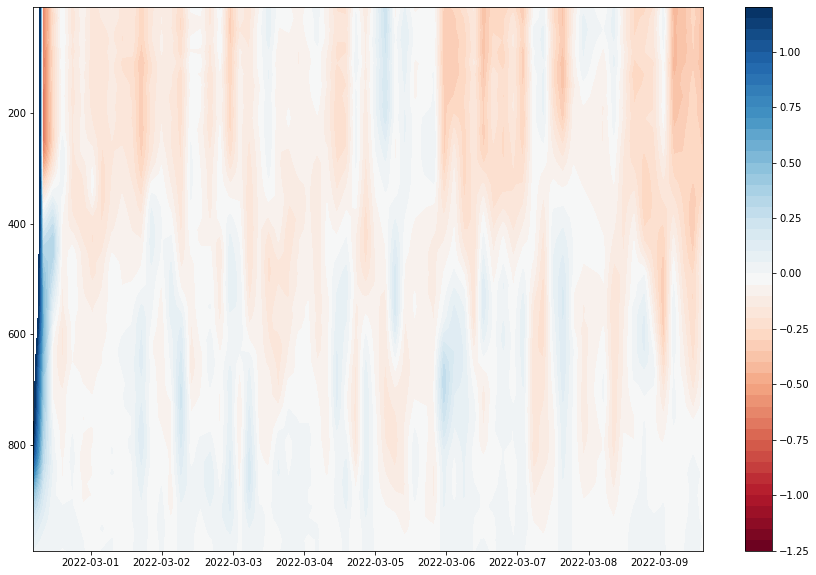

In [19]:
plt.figure(figsize=(15,10))
plt.contourf(ds.time[41:],ds.depth,ds.u_grid[:,41:],levels=np.arange(-1.25,1.25,0.05),cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar()

## Testing complex velocity variance

### First filter out profiles that don't make it to 1000 meters

In [20]:
# uvelnanind = np.sum(np.isnan(ds.u_grid.values),axis=0)
# vvelnanind = np.sum(np.isnan(ds.v_grid.values),axis=0)
# lowuvelnanind = np.where(uvelnanind>5)[0]
# lowvvelnanind = np.where(vvelnanind>5)[0]

# ds.u_grid[:,lowuvelnanind] = np.NaN
# ds.v_grid[:,lowvvelnanind] = np.NaN

# ## Manually ditching this one because it is an outlier
# #ds.u_grid[:,41] = np.NaN
# #ds.v_grid[:,41] = np.NaN


In [21]:
# complex_vel = np.empty((len(ds.depth),len(ds.time)),dtype = 'complex_')
# complex_vel[:] = np.NaN

# for x in np.arange(0,len(ds.start_time)):
#     ds2 = ds.sel(time=slice(ds.start_time[x],ds.end_time[x]))
#     gdf2 = gdf.loc[(gdf.time.values >= ds2.start_time.values[0]) & (gdf.time.values <= ds2.end_time.values[0])]
    
#     complex_vel[:,x] = np.array(list(map(complex,ds2.u_grid.values,ds2.v_grid.values)))
    


In [22]:
# complex_vel_var = np.nanvar(complex_vel,axis=1)

# plt.figure(figsize=(10,10))
# #plt.plot(np.nanmean(ds.obs_per_bin[:,41:],axis=1)/1000,ds.depth,color='tab:blue',label='Mean Observations per Bin')

# plt.plot(complex_vel_var,ds.depth,color='tab:orange')
# plt.gca().invert_yaxis()
# plt.ylabel('Depth')
# plt.xlabel('Complex Velocity Variance')
# plt.title('RU36 2022 Pathfinder')
# plt.xlim(0,1)

# ## This isn't right so manually pick the point just past 200 meters (similar to Todd)
# #min_var_ind = np.where(complex_vel_var == np.nanmin(complex_vel_var))[0]
# #plt.plot(complex_vel_var[min_var_ind],ds.depth[min_var_ind],'.',markersize=20)

# #min_var_ind = 26
# # min_var_ind = 29
# # plt.plot(complex_vel_var[min_var_ind],ds.depth[min_var_ind],'.',markersize=25)

In [23]:
# complex_vel_var = np.nanvar(complex_vel,axis=1)

# plt.figure(figsize=(10,10))
# #plt.plot(np.nanmean(ds.obs_per_bin[:,41:],axis=1)/1000,ds.depth,color='tab:blue',label='Mean Observations per Bin')

# plt.plot(complex_vel_var,ds.depth,color='tab:orange')
# plt.gca().invert_yaxis()
# plt.ylabel('Depth')
# plt.xlabel('Complex Velocity Variance')
# plt.title('RU36 2022 Pathfinder')
# plt.xlim(0,1)


# ## This isn't right so manually pick the point just past 200 meters (similar to Todd)
# #min_var_ind = np.where(complex_vel_var == np.nanmin(complex_vel_var))[0]
# #plt.plot(complex_vel_var[min_var_ind],ds.depth[min_var_ind],'.',markersize=20)

# #min_var_ind = 26
# # min_var_ind = 29
# # plt.plot(complex_vel_var[min_var_ind],ds.depth[min_var_ind],'.',markersize=25)

## Ok now attempt to do the linear fit to the velocity profiles below Zo

### Rotate to along and cross glider first

In [24]:
# along_vel    = np.empty((len(ds.depth),len(ds.time)))
# along_vel[:] = np.NaN
# cross_vel    = np.empty((len(ds.depth),len(ds.time)))
# cross_vel[:] = np.NaN


# for x in np.arange(0,len(ds.start_time)):
#     ds2 = ds.sel(time=slice(ds.start_time[x],ds.end_time[x]))
#     gdf2 = gdf.loc[(gdf.time.values >= ds2.start_time.values[0]) & (gdf.time.values <= ds2.end_time.values[0])]
    
#     mean_heading = np.nanmean(gdf2.m_heading)

#     along_vel[:,x] = (ds2.u_grid.values[:,0]*np.sin(mean_heading) + ds2.v_grid.values[:,0]*np.cos(mean_heading))
#     cross_vel[:,x] = (ds2.u_grid.values[:,0]*np.cos(mean_heading) + ds2.v_grid.values[:,0]*np.sin(mean_heading))
        

In [25]:
# along_vel    = np.empty((len(ds.depth),len(ds.time)))
# along_vel[:] = np.NaN
# cross_vel    = np.empty((len(ds.depth),len(ds.time)))
# cross_vel[:] = np.NaN
# mean_heading = np.empty(len(ds.time))
# mean_heading[:] = np.NaN
# cross_head = np.empty(len(ds.time))
# cross_head[:] = np.NaN

# for x in np.arange(0,len(ds.start_time)):
#     ds2 = ds.sel(time=slice(ds.start_time[x],ds.end_time[x]))
#     gdf2 = gdf.loc[(gdf.time.values >= ds2.start_time.values[0]) & (gdf.time.values <= ds2.end_time.values[0])]
    
#     mean_heading[x] = np.nanmedian(np.deg2rad(gdf2.corrected_heading))
#     cross_head[x] = mean_heading[x] + np.deg2rad(90)
# #     if cross_head[x] > 2*np.pi:
# #         cross_head[x] = cross_head[x] - (2*np.pi)

#     along_vel[:,x] = (ds2.u_grid.values[:,0]/np.sin(mean_heading[x])) + (ds2.v_grid.values[:,0]/np.cos(mean_heading[x]))
#     cross_vel[:,x] = (ds2.u_grid.values[:,0]/np.cos(cross_head[x])) + (ds2.v_grid.values[:,0]/np.sin(cross_head[x]))
        

### Pull out mean profile next

In [26]:
# mean_along_profile_Zo = np.nanmean(along_vel[min_var_ind:-1,:],axis=1)
# mean_cross_profile_Zo = np.nanmean(cross_vel[min_var_ind:-1,:],axis=1)

### How representative is the mean along glider velocity profile of the spread of along glider velocity profiles

In [27]:
# plt.figure(figsize=(15,10))
# plt.plot(mean_along_profile_Zo,ds.depth[min_var_ind:-1],'tab:blue',linewidth=5,label='Mean Along Glider Velocity Below Zo');
# plt.plot(along_vel[min_var_ind:-1,:],ds.depth[min_var_ind:-1],'tab:grey',alpha=0.5);
# plt.gca().invert_yaxis()
# #plt.xlim((-5,5))


In [28]:
# plt.figure(figsize=(15,10))
# plt.plot(mean_cross_profile_Zo,ds.depth[min_var_ind:-1],'tab:blue',linewidth=5,label='Mean Cross Glider Velocity Below Zo');
# plt.plot(cross_vel[min_var_ind:-1,:],ds.depth[min_var_ind:-1],'tab:grey',alpha=0.5);
# plt.gca().invert_yaxis()


## Linear fit

In [29]:
# dep_2_model = ds.depth[min_var_ind:-1].values
# dep_2_fit = ds.depth.values

# slope, intercept, r, p, se = stats.linregress(dep_2_model, mean_along_profile_Zo)


# fit = intercept + slope*dep_2_fit
# fit2 = intercept + slope*dep_2_model

In [30]:
# plt.figure(figsize=(15,10))
# plt.plot(mean_along_profile_Zo,ds.depth[min_var_ind:-1],'tab:blue',linewidth=5,label='Mean Along Glider Velocity Below Zo');
# plt.plot(fit,dep_2_fit, '--r', linewidth=2,label='fitted line')
# plt.legend()
# plt.gca().invert_yaxis()


### Mean of the fit

In [31]:
# fit_mean = np.nanmean(fit)
# fit_mean

### Remove mean of the fit

In [32]:
# fit_wout_mean = fit-fit_mean

# ## Check that it is equal to 0
# np.nanmean(fit_wout_mean)

In [33]:
# fit_wout_mean2 = fit2-fit_mean2

# ## Check that it is equal to 0
# np.nanmean(fit_wout_mean2)

### Remove new fit from mean profile

In [34]:
# mean_along_w_fit_removed = mean_along_profile_Zo-fit_wout_mean2

In [35]:
# plt.figure(figsize=(15,10))
# plt.plot(mean_along_profile_Zo,ds.depth[min_var_ind:-1],'tab:blue',linewidth=5,label='Mean Along Glider Velocity Below Zo');
# plt.plot(fit_wout_mean,dep_2_fit, '--r', linewidth=2,label='fitted line w/out mean')
# plt.legend()
# plt.gca().invert_yaxis()


In [36]:
# plt.figure(figsize=(15,10))
# plt.plot(mean_along_profile_Zo,ds.depth[min_var_ind:-1],'tab:blue',linewidth=5,label='Mean Along Glider Velocity Below Zo');
# plt.plot(fit_wout_mean2,dep_2_model, '--r', linewidth=2,label='fitted line w/out mean')
# plt.plot(mean_along_w_fit_removed,dep_2_model, '--b', linewidth=2,label='Mean Along Glider Velocity w/ mean removed')
# plt.legend()
# plt.gca().invert_yaxis()


### Along glider shear bias per 1000 meters

In [37]:
# fit_wout_mean2[0]-fit_wout_mean2[-1]

### Remove fit w/out mean from all along glider velocity profiles

In [38]:
# new_along_vel = along_vel.transpose()-fit_wout_mean
# ## transpose back to original dimensions
# new_along_vel = new_along_vel.transpose()

In [39]:
# plt.figure(figsize=(10,10))
# plt.plot(along_vel,ds.depth.values,color='tab:orange',label='Original Along Glider Velocity Profiles')
# plt.plot(new_along_vel,ds.depth.values,color='tab:blue',label='Corrected Along Glider Velocity Profiles')
# plt.gca().invert_yaxis()
# #plt.legend()

## Now rotate back

In [40]:
# corrected_u_grid    = np.empty((len(ds.depth),len(ds.time)))
# corrected_u_grid[:] = np.NaN
# corrected_v_grid    = np.empty((len(ds.depth),len(ds.time)))
# corrected_v_grid[:] = np.NaN


# for x in np.arange(0,len(ds.start_time)):
#     ds2 = ds.sel(time=slice(ds.start_time[x],ds.end_time[x]))
#     gdf2 = gdf.loc[(gdf.time.values >= ds2.start_time.values[0]) & (gdf.time.values <= ds2.end_time.values[0])]
    
#     mean_heading = np.nanmedian(np.deg2rad(gdf2.corrected_heading))
#     cross_head = mean_heading + np.deg2rad(90)

#     corrected_u_grid[:,x] = (new_along_vel[:,x]*np.sin(mean_heading) + cross_vel[:,x]*np.cos(cross_head))
#     corrected_v_grid[:,x] = (new_along_vel[:,x]*np.cos(mean_heading) + cross_vel[:,x]*np.sin(cross_head))
        

In [41]:
# plt.figure(figsize=(18,10))
# plt.pcolormesh(ds.time.values,ds.depth,corrected_u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
# plt.gca().invert_yaxis()
# plt.colorbar(label='EW Velocity [m/s]')
# plt.title('CORRECTED 4 SHEAR BIAS \n RU36 2022 St. Thomas-St. Croix')
# plt.gcf().autofmt_xdate()
# #plt.xlim([datetime.date(2022, 2, 27), datetime.date(2022, 2, 28)])

In [42]:
# plt.figure(figsize=(18,10))
# plt.pcolormesh(ds.time.values,ds.depth,corrected_v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
# plt.gca().invert_yaxis()
# plt.colorbar(label='N-S Velocity [m/s]')
# plt.title('CORRECTED 4 SHEAR BIAS \n RU36 2022 St. Thomas-St. Croix')
# plt.gcf().autofmt_xdate()
# #plt.xlim([datetime.date(2022, 2, 27), datetime.date(2022, 2, 28)])

## Manually pick out points? Based on Google Earth KMZ

In [43]:
#2022-02-27 15:36:47 # Start #1
#2022-03-01 03:50:37 # End #1

#2022-03-01 03:50:37 # Start #2
#2022-03-02 13:07:40 # End #2

#2022-03-02 16:23:19 # Start #3
#2022-03-03 22:10:11 # End #3

#2022-03-03 22:10:11 # Start #4
#2022-03-05 06:43:08 # End #4

#2022-03-05 06:43:08 # Start #5
#2022-03-06 15:50:51 # End #5

#2022-03-06 15:50:51 # Start #6
#2022-03-08 01:36:52 # End #6

#2022-03-08 01:36:52 # Start #7
#2022-03-09 11:18:04 # End #7

#2022-03-09 11:18:04 # Start #8
#2022-03-11 01:01:33 # End #8


In [44]:
start_ind1 = '2022-02-27 15:36:47'
end_ind1   = '2022-03-01 03:50:37'

start_ind2 = '2022-03-01 03:50:37'
end_ind2   = '2022-03-02 13:07:40'

start_ind3 = '2022-03-02 16:23:19'
end_ind3   = '2022-03-03 22:10:11'

start_ind4 = '2022-03-03 22:10:11'
end_ind4   = '2022-03-05 06:43:08'

start_ind5 = '2022-03-05 06:43:08'
end_ind5   = '2022-03-06 15:50:51'

start_ind6 = '2022-03-06 15:50:51'
end_ind6   = '2022-03-08 01:36:52'

start_ind7 = '2022-03-08 01:36:52'
end_ind7   = '2022-03-09 11:18:04'

start_ind8 = '2022-03-09 11:18:04'
end_ind8   = '2022-03-11 01:01:33'

transect_start_times = [start_ind1, start_ind2, start_ind3, start_ind4, start_ind5, start_ind6, start_ind7, start_ind8]
transect_end_times   = [end_ind1, end_ind2, end_ind3, end_ind4, end_ind5, end_ind6, end_ind7, end_ind8]

sci_gdf.time = pd.to_datetime(sci_gdf.time)
sci_gdft = sci_gdf.set_index('time')

In [45]:
sci_gdft.loc[transect_start_times[0]:transect_end_times[0]]

/tmp/ipykernel_44412/3365399263.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdft.loc[transect_start_times[0]:transect_end_times[0]]


,depth,latitude,longitude,salinity,temperature,density,source_file,profile_id
time,,,,,,,,
2022-02-27 15:45:02.250,0.199098,18.153421,-64.798841,3.597648e+01,2.613796e+01,1.023729e+03,ru36-2022-055-0-51-dbd(00320051),1645979664
2022-02-27 15:45:03.110,NaN,18.153422,-64.798842,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-055-0-51-dbd(00320051),1645979664
2022-02-27 15:45:03.250,NaN,18.153422,-64.798842,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-055-0-51-dbd(00320051),1645979664
2022-02-27 15:45:04.250,0.269274,18.153422,-64.798843,3.597707e+01,2.613734e+01,1.023730e+03,ru36-2022-055-0-51-dbd(00320051),1645979664
2022-02-27 15:45:05.250,0.274343,18.153423,-64.798844,3.597683e+01,2.613764e+01,1.023730e+03,ru36-2022-055-0-51-dbd(00320051),1645979664
...,...,...,...,...,...,...,...,...
2022-03-01 03:48:56.470,0.247609,17.824295,-64.799942,3.587334e+01,2.637804e+01,1.023576e+03,ru36-2022-058-0-6-dbd(00330006),1646103966
2022-03-01 03:48:57.500,0.239757,17.824293,-64.799941,3.587557e+01,2.637724e+01,1.023578e+03,ru36-2022-058-0-6-dbd(00330006),1646103966
2022-03-01 03:48:58.500,NaN,17.824290,-64.799939,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-058-0-6-dbd(00330006),1646103966


In [46]:
sci_gdf1 = sci_gdft.loc[transect_start_times[0]:transect_end_times[0]]
sci_gdf2 = sci_gdft.loc[transect_start_times[1]:transect_end_times[1]]
sci_gdf3 = sci_gdft.loc[transect_start_times[2]:transect_end_times[2]]
sci_gdf4 = sci_gdft.loc[transect_start_times[3]:transect_end_times[3]]
sci_gdf5 = sci_gdft.loc[transect_start_times[4]:transect_end_times[4]]
sci_gdf6 = sci_gdft.loc[transect_start_times[5]:transect_end_times[5]]
sci_gdf7 = sci_gdft.loc[transect_start_times[6]:transect_end_times[6]]
sci_gdf8 = sci_gdft.loc[transect_start_times[7]:transect_end_times[7]]
sci_gdf8

/tmp/ipykernel_44412/970798355.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf1 = sci_gdft.loc[transect_start_times[0]:transect_end_times[0]]
/tmp/ipykernel_44412/970798355.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf2 = sci_gdft.loc[transect_start_times[1]:transect_end_times[1]]
/tmp/ipykernel_44412/970798355.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf3 = sci_gdft.loc[transect_start_times[2]:transect_end_times[2]]
/tmp/ipykernel_44412/970798355.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Ve

,depth,latitude,longitude,salinity,temperature,density,source_file,profile_id
time,,,,,,,,
2022-03-09 11:29:21.250,0.178326,17.828615,-64.807637,3.584689e+01,2.627026e+01,1.023590e+03,ru36-2022-060-0-98-dbd(00340098),1646827919
2022-03-09 11:29:22.250,NaN,17.828615,-64.807637,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-060-0-98-dbd(00340098),1646827919
2022-03-09 11:29:23.250,0.209041,17.828616,-64.807637,3.584745e+01,2.627175e+01,1.023590e+03,ru36-2022-060-0-98-dbd(00340098),1646827919
2022-03-09 11:29:24.250,0.353969,17.828616,-64.807637,3.584955e+01,2.627112e+01,1.023592e+03,ru36-2022-060-0-98-dbd(00340098),1646827919
2022-03-09 11:29:25.110,NaN,17.828617,-64.807637,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-060-0-98-dbd(00340098),1646827919
...,...,...,...,...,...,...,...,...
2022-03-11 00:55:47.000,NaN,18.152295,-64.794844,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-060-0-128-dbd(00340128),1646957781
2022-03-11 00:55:47.210,NaN,18.152296,-64.794843,9.969210e+36,9.969210e+36,9.969210e+36,ru36-2022-060-0-128-dbd(00340128),1646957781
2022-03-11 00:55:48.000,1.566237,18.152297,-64.794842,3.627263e+01,2.626925e+01,1.023917e+03,ru36-2022-060-0-128-dbd(00340128),1646957781


## What to do about transect 1 with the bad GPS hit?

### Fix by just making all lons -64.8

In [47]:
sci_gdf1.longitude = [-64.8]*len(sci_gdf1.latitude)

## Take a peak at subsetting the ADCP dataframe now

In [48]:
ds

<xarray.Dataset>
Dimensions:      (depth: 50, time: 108)
Coordinates:
  * time         (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03...
  * depth        (depth) float64 10.0 30.0 50.0 70.0 ... 930.0 950.0 970.0 990.0
Data variables:
    u_grid       (depth, time) float64 -0.3124 -0.3747 ... 0.009932 -0.00582
    v_grid       (depth, time) float64 -0.0385 0.08768 ... -0.008129 0.0217
    obs_per_bin  (depth, time) float64 212.0 154.0 329.0 ... 95.0 144.0 477.0
    latitude     (time) float64 18.15 18.15 18.15 18.15 ... 17.87 17.84 17.83
    longitude    (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_lat    (time) float64 18.15 18.15 18.15 18.15 ... 17.88 17.85 17.83
    start_lon    (time) float64 -64.79 -64.8 -64.8 ... -64.81 -64.81 -64.81
    end_lat      (time) float64 18.15 18.15 18.15 18.15 ... 17.85 17.83 17.84
    end_lon      (time) float64 -64.8 -64.8 -64.8 -64.8 ... -64.81 -64.81 -64.8
    start_time   (time) datetime64[ns] 2022-02-24T18:29:31.830000 ... 2022-03...
    end_time     (time) datetime64[ns] 2022-02-24T20:07:10.130000 ... 2022-03...
Attributes:
    description:  Master/combined RU36 2022 RDI ADCP least-squares inversion ...

In [49]:
# subset_ds1 = ds.sel(time=slice(start_ind1,end_ind1))
# subset_ds2 = ds.sel(time=slice(start_ind2,end_ind2))
# subset_ds3 = ds.sel(time=slice(start_ind3,end_ind3))
# subset_ds4 = ds.sel(time=slice(start_ind4,end_ind4))
# subset_ds5 = ds.sel(time=slice(start_ind5,end_ind5))
# subset_ds6 = ds.sel(time=slice(start_ind6,end_ind6))
# subset_ds7 = ds.sel(time=slice(start_ind7,end_ind7))
# subset_ds8 = ds.sel(time=slice(start_ind8,end_ind8))

# subset_ds1

In [50]:
y=1
DACdf2 = DACdf.loc[(DACdf.start_time >= transect_start_times[y]) & (DACdf.end_time >= transect_end_times[y]) ]
DACdf2

,vx,vy,start_lon,start_lat,end_lon,end_lat,start_time,end_time
137,-0.056944,0.004883,-64.796015,18.133328,-64.803502,18.134043,2022-03-02 13:09:24.260000+00:00,2022-03-02 16:18:11.080000+00:00
144,-0.049872,0.002074,-64.803502,18.134043,-64.804328,18.099943,2022-03-02 16:30:27.250000+00:00,2022-03-02 19:38:36.750000+00:00
145,-0.049872,0.002074,-64.804328,18.099943,-64.804328,18.099943,2022-03-02 19:53:11.290000+00:00,2022-03-02 19:53:43.340000+00:00
146,-0.055331,0.017787,-64.807380,17.963252,-64.807380,17.963252,2022-03-03 08:53:42.300000+00:00,2022-03-03 08:54:12.090000+00:00
147,-0.135943,0.008762,-64.798285,17.839872,-64.801518,17.870890,2022-03-09 14:45:27.590000+00:00,2022-03-09 18:03:55.200000+00:00
...,...,...,...,...,...,...,...,...
396,-0.099611,0.000121,-64.815107,18.161050,-64.815107,18.161050,2022-03-17 01:40:54.640000+00:00,2022-03-17 01:42:33.650000+00:00
397,-0.046964,-0.008903,-64.815107,18.161050,-64.829722,18.169372,2022-03-17 01:42:37.650000+00:00,2022-03-17 03:19:50.990000+00:00
398,-0.046964,-0.008903,-64.829722,18.169372,-64.829722,18.169372,2022-03-17 03:19:55+00:00,2022-03-17 03:21:48.990000+00:00
399,-0.016464,-0.036245,-64.829722,18.169372,-64.826620,18.167968,2022-03-17 03:21:52.990000+00:00,2022-03-17 05:03:21.580000+00:00


## Try the latitude grid interpolation I did on the RU29 data

In [51]:
## OG lat grid
lat_grid = np.arange(17.8,18.16,0.05)
## Coarser lat grid 
#lat_grid = np.arange(17.8,18.16,0.1) ## This is essentially 3 11 km chunks (South, Middle, North)
## lon_grid
lon_grid = np.repeat(-64.80,8) # Just make it -64.80
## vertical grid
#griddepth = np.arange(2.5,1023,10)
#griddepth = np.arange(np.min(ds.depth),np.max(ds.depth)+dz,dz)
griddepth = ds.depth.values
## Make grid
X, Y, Z = np.meshgrid(lon_grid, lat_grid, griddepth)



gridvelu = np.empty((len(griddepth),len(lat_grid),8))
gridvelu[:] = np.NaN
gridvelv = np.empty((len(griddepth),len(lat_grid),8))
gridvelv[:] = np.NaN
gridtemp = np.empty((len(griddepth),len(lat_grid),8))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(lat_grid),8))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(lat_grid),8))
griddensity[:] = np.NaN
gridvx = np.empty((len(lat_grid),8))
gridvx[:] = np.NaN
segtimes = np.empty((len(lat_grid),8),dtype='datetime64[s]')



## Go 1:7 because the 1st transect has a weird DAC on one leg and the last transect is cut short
for y in np.arange(0,8):

    ## ADCP
    subset_ds_sect = ds.sel(time=slice(transect_start_times[y],transect_end_times[y]))
    sci_gdf = sci_gdft.loc[transect_start_times[y]:transect_end_times[y]]
    DACdf2 = DACdf.loc[(DACdf.start_time >= transect_start_times[y]) & (DACdf.end_time >= transect_end_times[y]) ]
    
    
    tot_dt = (subset_ds_sect.time.values[-1]-subset_ds_sect.time.values[0])/len(lat_grid)
    tot_dt = tot_dt.astype('timedelta64[h]')
    tot_dt = tot_dt.astype('float64')
    
#     segtimes[:,y] = np.arange(pd.to_datetime(subset_ds_sect.time.values[0]).tz_localize(None), pd.to_datetime(subset_ds_sect.time.values[-1]).tz_localize(None), datetime.timedelta(hours = tot_dt)).astype('datetime64')
    segtimes[:,y] = np.array([pd.to_datetime(subset_ds_sect.time.values[0]).tz_localize(None) + datetime.timedelta(hours=tot_dt*i) for i in np.arange(0,len(lon_grid))])

    
    profile_IDs = np.unique(sci_gdf.profile_id)
    profileid_start_index = np.empty(len(profile_IDs),dtype='int')
    profileid_end_index = np.empty(len(profile_IDs),dtype='int')
    
    for x in np.arange(0,len(profile_IDs)):
        profileid_start_index[x] = np.where(sci_gdf.profile_id == profile_IDs[x])[0][0]
        profileid_end_index[x] = np.where(sci_gdf.profile_id == profile_IDs[x])[0][-1]
    
    tgriddensity = np.empty((len(griddepth),len(profile_IDs)))
    tgriddensity[:] = np.NaN
    tgridtemp = np.empty((len(griddepth),len(profile_IDs)))
    tgridtemp[:] = np.NaN
    tgridsalinity = np.empty((len(griddepth),len(profile_IDs)))
    tgridsalinity[:] = np.NaN
    profile_lats = np.empty((len(profile_IDs)))
    profile_lats[:] = np.NaN
    profile_lons = np.empty((len(profile_IDs)))
    profile_lons[:] = np.NaN
    
    
    for x in np.arange(0,len(profile_IDs)):
        tgriddensity[:,x] = interp.griddata(sci_gdf.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf.density.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridtemp[:,x] = interp.griddata(sci_gdf.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf.temperature.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        tgridsalinity[:,x] = interp.griddata(sci_gdf.depth.values[profileid_start_index[x]:profileid_end_index[x]],sci_gdf.salinity.values[profileid_start_index[x]:profileid_end_index[x]],griddepth)
        profile_lats[x] = sci_gdf.latitude.values[profileid_start_index[x]]
        profile_lons[x] = sci_gdf.longitude.values[profileid_start_index[x]]

    ## Drop columns of all nan
    tgridtemp = tgridtemp[:,~np.isnan(tgridtemp).all(axis=0)]
    tgridsalinity = tgridsalinity[:,~np.isnan(tgridsalinity).all(axis=0)]
    tgriddensity = tgriddensity[:,~np.isnan(tgriddensity).all(axis=0)]
    
    gridvx[:,y] = interp.griddata(DACdf2.start_lat.values, DACdf2.vx.values, lat_grid, method='nearest')
    

    for x in np.arange(0,len(griddepth)):
        gridvelu[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.u_grid.values[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y] = interp.griddata(subset_ds_sect.latitude.values, subset_ds_sect.v_grid.values[x,:], lat_grid, method='nearest')
       
        gridtemp[x,:,y] = interp.griddata(profile_lats, tgridtemp[x,:], lat_grid, method='nearest')
        gridsalinity[x,:,y] = interp.griddata(profile_lats, tgridsalinity[x,:], lat_grid, method='nearest')
        griddensity[x,:,y] = interp.griddata(profile_lats, tgriddensity[x,:], lat_grid, method='nearest')

totgriddensity = np.nanmean(griddensity,axis=2)

meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)

/tmp/ipykernel_44412/500209576.py:37: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf = sci_gdft.loc[transect_start_times[y]:transect_end_times[y]]
/tmp/ipykernel_44412/500209576.py:37: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf = sci_gdft.loc[transect_start_times[y]:transect_end_times[y]]
/tmp/ipykernel_44412/500209576.py:37: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  sci_gdf = sci_gdft.loc[transect_start_times[y]:transect_end_times[y]]
/tmp/ipykernel_44412/500209576.py:37: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future V

## Make and save dridded dataset

In [52]:
grid_ds = xr.Dataset(
    data_vars=dict(
        u =(["depth", "lat", "transect_num"], gridvelu),
        v =(["depth", "lat", "transect_num"], gridvelv),
        temp = (["depth", "lat", "transect_num"], gridtemp),
        sal = (["depth", "lat", "transect_num"], gridsalinity),
        density = (["depth", "lat", "transect_num"], griddensity),
        time = (["lat", "transect_num"],   segtimes)
    ),
    coords=dict(
        depth=inversion_depth,
        lat=lat_grid,
        transect_num = np.arange(1,9)
    ),
    attrs=dict(description="Processed RU36 ADCP and CTD data from the March 2022 Deployment. Gridded/interpolated onto transect latitude grid"),
)

grid_ds

<xarray.Dataset>
Dimensions:       (depth: 50, lat: 8, transect_num: 8)
Coordinates:
  * depth         (depth) float64 10.0 30.0 50.0 70.0 ... 950.0 970.0 990.0
  * lat           (lat) float64 17.8 17.85 17.9 17.95 18.0 18.05 18.1 18.15
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8
Data variables:
    u             (depth, lat, transect_num) float64 -0.1801 ... 0.009932
    v             (depth, lat, transect_num) float64 -0.09921 ... -0.008129
    temp          (depth, lat, transect_num) float64 26.41 26.41 ... 9.969e+36
    sal           (depth, lat, transect_num) float64 35.96 35.94 ... 9.969e+36
    density       (depth, lat, transect_num) float64 1.024e+03 ... 9.969e+36
    time          (lat, transect_num) datetime64[ns] 2022-02-27T15:38:42 ... ...
Attributes:
    description:  Processed RU36 ADCP and CTD data from the March 2022 Deploy...

In [53]:
fname = "/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Gridded_ADCP_CTD.nc"

grid_ds.to_netcdf(fname)